In [70]:
%reset
%matplotlib inline
import networkx as nx
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import cmath as c

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# README

## Functions:
#### run_model
- input: adjacency matrix, coupling constant, time
- output: time series for all nodes

#### state_course
- input: POModel
- output: displays sin of phases

#### R_course
- input: POModel
- output: displays synchrony over time

#### disp_course
- input: adjacency matrix, coupling constant, time
- output: displays synchrony over time

#### R_sweep
- input: adjacency matrix, starting coupling constant, ending coupling constant, number of K values to test
- output: displays average R for given K

#### edge_R_sweep
- input: adjacency matrix, starting coupling constant, ending coupling constant, number of K values to test
- output: displays average R for given K for all edges

#### gen_models
- input: none
- output: results for all possible models

## Data:

#### POModel:
- Phase Oscillator Model
- self.G: Graph
- self.states: memory of phases
- self.w: init intrinsic freq.
- self.t: time
- self.K: coupling constant
- self.dt: time step
- self.X: weight multiplier

In [82]:
class POModel:
    def __init__(self, A, K = 1, dt = .01):
        self.G = nx.from_numpy_matrix(A) #Graph
        self.states = np.matrix(np.random.uniform(0,2*np.pi,size=(6,1)))# memory of phases
        self.w = np.matrix(np.random.normal(3,.001,size=(6,1))) #init intrinsic freq.
        self.t = 0 #time
        self.K = K #coupling constant
        self.dt = dt #time step
        self.X = np.identity(len(G.edges()))
    
    #Kuramoto differential equation
    def phase_dev(self,phase):
        D = (nx.incidence_matrix(self.G, oriented = True)).todense() #incidence
        D = D * self.X
        N = np.random.normal(0, 10, [len(D[0]), 1])
        return self.w - self.K / len(self.G) * D * np.sin(D.T * self.states[:,-1]) + N
    
    # 4th order Runge-Kutta approximation
    def step(self):
        new_state = self.states[:,-1] + self.phase_dev(self.states[:,-1])*self.dt
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))
        '''
        k1 = self.phase_dev(self.states[:,-1])*self.dt
        k2 = self.phase_dev(self.states[:,-1]+ .5*k1)*self.dt
        k3 = self.phase_dev(self.states[:,-1]+ .5*k2)*self.dt
        k4 = self.phase_dev(self.states[:,-1]+ k3)*self.dt
        new_state = self.states[:,-1] + (k1+ 2*k2 + 2*k3 + k4)/6
        new_state = new_state % (2 * np.pi)
        self.t += self.dt
        self.states = np.hstack((self.states,new_state))  
        '''

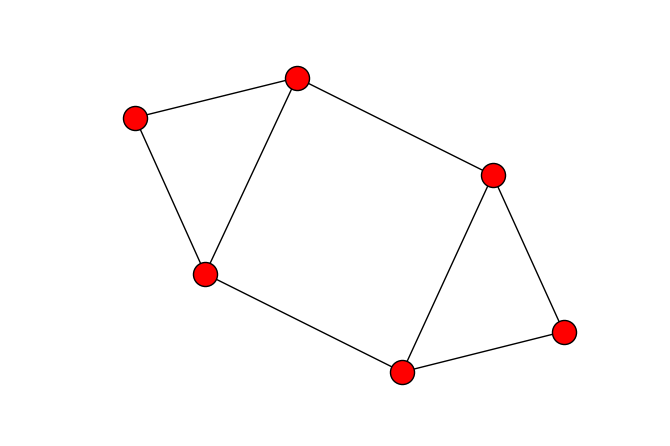

In [72]:
nodes = [1,2,3,4,5,6]
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from([(1,2),(2,3),(1,3),(3,4),(4,5),(4,6),(5,6),(1,6)])


#Quick plot of G
nx.draw(G)
A = nx.to_numpy_matrix(G)

In [73]:
def run_model(A, K = 1, t = 10):
    P = POModel(A, K)
    for ts in range(0,int(t/P.dt)):
        P.step()
    return P

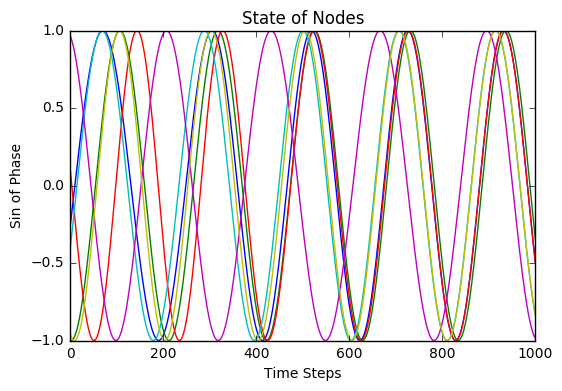

In [74]:
def state_course(P):
    plt.figure()
    plt.plot(np.sin(P.states.T))
    plt.xlabel('Time Steps')
    plt.ylabel('Sin of Phase')
    plt.title('State of Nodes')
    plt.show()
state_course(run_model(A))

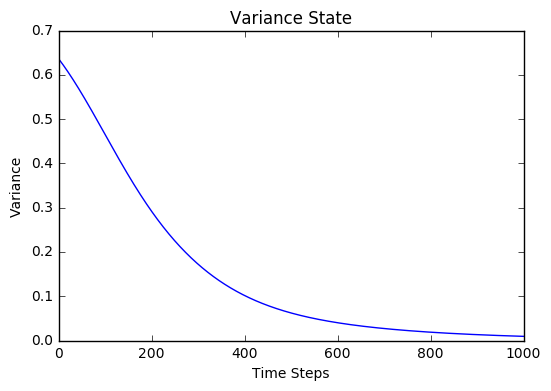

In [75]:
def R_course(P):
    Var = []
    for x in np.array(P.states.T):
        z = [c.exp(complex(0,phase)) for phase in x]
        z = sum(z)/len(z)
        Var.append(1-abs(z))
    plt.figure()
    plt.plot(Var)
    plt.xlabel('Time Steps')
    plt.ylabel('Variance')
    plt.title('Variance State')
    plt.show()
R_course(run_model(A))

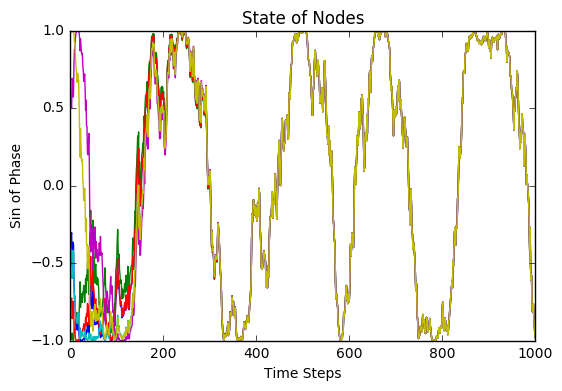

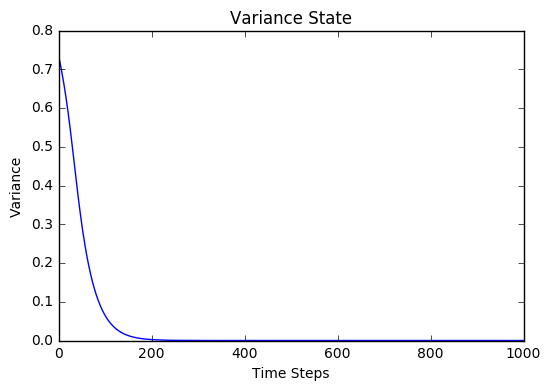

In [83]:
def disp_course(A, K = 10, t = 10):
    P = run_model(A, K, t)
    state_course(P)
    R_course(P)
disp_course(A)
    

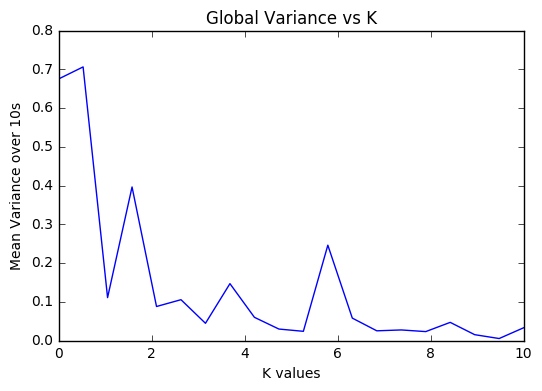

In [84]:
def R_sweep(A, Ki = 0, Kf = 10, N = 20):
    def calcR(P):
        Var = []
        for x in np.array(P.states.T):
            z = [c.exp(complex(0,phase)) for phase in x]
            z = sum(z)/len(z)
            Var.append(1-abs(z))
        return sum(Var)/len(Var)
    KVar = []
    KSpan = np.linspace(Ki,Kf, num = N)
    for K in KSpan:
        P = run_model(A,K,t = 10)
        KVar.append(calcR(P))
    plt.figure()
    plt.plot(KSpan,KVar)
    plt.xlabel('K values')
    plt.ylabel('Mean Variance over 10s')
    plt.title('Global Variance vs K')
    plt.show()
    return (KSpan, KVar)
KVal = R_sweep(A)

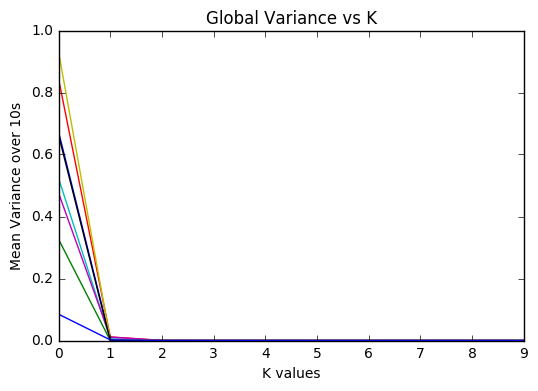

In [78]:
def edge_R_sweep(A, Ki = 0, Kf = 10, N = 10):
    def calc_edgeR(P):
        for x in np.array(P.states.T):
            z = [c.exp(complex(0,phase)) for phase in x]
            edgeR = [1 - abs((z[a] + z[b]) / 2) for (a,b) in P.G.edges()]
        return edgeR
    KVar = []
    KSpan = np.linspace(Ki,Kf, num = N)
    for K in KSpan:
        P = run_model(A,K,t = 10)
        KVar.append(calc_edgeR(P))
    plt.figure()
    plt.plot(KVar)
    plt.xlabel('K values')
    plt.ylabel('Mean Variance over 10s')
    plt.title('Global Variance vs K')
    plt.show()
    return (KSpan, KVar)
KVal = edge_R_sweep(A)

In [79]:
def gen_models(A, time = 1):
    list_models = []
    list_models.append((A,run_model(A,time).states))
    SyncK = 10
    for i in range(6):
        for j in range(i):
            if A[i,j] != 0:
                list_models.append((A,run_model(B,time).states))
                B = A.copy()
                B[i,j] = 10
                B[j,i] = 10
                list_models.append((A,run_model(B,time).states))
    return list_models
p = gen_models(A)

UnboundLocalError: local variable 'B' referenced before assignment

  (0, 0)	1.0
  (1, 0)	1.0
  (0, 1)	1.0
  (2, 1)	1.0
  (0, 2)	1.0
  (5, 2)	1.0
  (1, 3)	1.0
  (2, 3)	1.0
  (2, 4)	1.0
  (3, 4)	1.0
  (3, 5)	1.0
  (4, 5)	1.0
  (3, 6)	1.0
  (5, 6)	1.0
  (4, 7)	1.0
  (5, 7)	1.0
[[ 1.  1.  1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  1.  0.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  1.  1.]]
[[ 0.  1.  1.  0.  0.  1.]
 [ 1.  0.  1.  0.  0.  0.]
 [ 1.  1.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  1.  1.]
 [ 0.  0.  0.  1.  0.  1.]
 [ 1.  0.  0.  1.  1.  0.]]


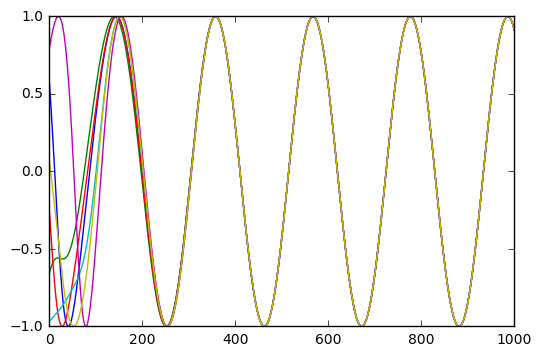

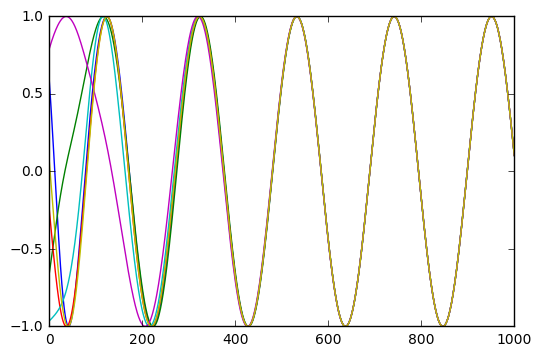

In [81]:
t = 10
P = POModel(A, K = 10)
n = 0

null = []
for ts in range(0,int(t/P.dt)):
    P.step()

plt.figure()
plt.plot(np.sin(P.states.T))
    
P.states = P.states[:,0]


P.X[3,3] = 0
P.X[7,7] = 0

hyp = []
for ts in range(0,int(t/P.dt)):
    P.step()
    
plt.figure()
plt.plot(np.sin(P.states.T))
plt.show()


## To Do
- finish generating models
- check synchrony methods, generate plots

## Notes
- R curve shows measure of synchrony, isn't linear: must decide on a "medium synchrony" K value, depends on variance of w
- Parameters to mess with: variance for w, noise
- Assessing phase difference over the timecourse: Here, we want to find the mean phase difference between all pairwise channels We'll plot this as a stacked gaussian
- Think that it is sensitive to initial conditions: phase + intrinsic freq. - maybe not so with a noise parameter